# Part 4: Predictive analysis
In this part we will train three predictive models on the data set and evaluate thier performance. The models are meant to predict the number of rentals given certain conditions (date and weather).

To train the models we use six features: hour, weekday, month, temperature, precipation, wind speed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime as dt

from yellowbrick.target import FeatureCorrelation

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

path = r"D:\Git\aa_project\Abgabe\Data"
path_fig = r"D:\Git\aa_project\Abgabe\Figures"

# 1. Predictive analysis perparation

## 1.1 Data import
First the rental data and weather data is imported and processed to be used in our predictive models.

For each hour the trips are counted and stored. As seen in the descriptive analysis, some data points from the Berlin data set are missing between 15. and  19.3.2019. This time interval is excluded from the training data.

In [2]:
#Berlin
df_b_base = pd.read_csv(path + r"\berlin_final.csv")
df_b_w = pd.read_csv(path + r"\berlin_weather.csv")

# Frankfurt
df_f_base = pd.read_csv(path + r"\frankfurt_final.csv")
df_f_w = pd.read_csv(path + r"\frankfurt_weather.csv")

In [3]:
def get_trips_berlin(datetime):
    return len(df_b_base[(df_b_base["month"] == datetime.month) & (df_b_base["date"] == datetime.day) & (df_b_base["hour"] == datetime.hour)].index)

def get_trips_frankfurt(datetime):
    return len(df_f_base[(df_f_base["month"] == datetime.month) & (df_f_base["date"] == datetime.day) & (df_f_base["hour"] == datetime.hour)].index)

In [4]:
df_f_w.drop(columns = ["sid", "Unnamed: 0"], inplace = True)
df_f_w.datetime = pd.to_datetime(df_f_w.datetime)
df_f_w["num_trips"] = df_f_w["datetime"].apply(get_trips_frankfurt)

df_b_w.drop(columns = ["sid", "Unnamed: 0"], inplace = True)
df_b_w.datetime = pd.to_datetime(df_b_w.datetime)
df_b_w["num_trips"] = df_b_w["datetime"].apply(get_trips_berlin)

In [5]:
def get_month(datetime):
    return datetime.month
def get_hour(datetime):
    return datetime.hour
def get_weekday(datetime):
    return datetime.weekday() + 1

In [6]:
df_f_w['month'] = df_f_w['datetime'].apply(get_month)
df_f_w['hour'] = df_f_w['datetime'].apply(get_hour)
df_f_w['weekday'] = df_f_w['datetime'].apply(get_weekday)

In [7]:
df_b_w['month'] = df_b_w['datetime'].apply(get_month)
df_b_w['hour'] = df_b_w['datetime'].apply(get_hour)
df_b_w['weekday'] = df_b_w['datetime'].apply(get_weekday)

In [8]:
start = dt.datetime.strptime('2019-03-15 13:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2019-03-19 08:00:00', '%Y-%m-%d %H:%M:%S')

df_b_w.drop(df_b_w[(df_b_w.datetime >= start) &
                   (df_b_w.datetime <= end)].index, inplace = True)

In [9]:
df_b = df_b_w[['month', 'weekday', 'hour', 'num_trips', 'temperature', 'precipitation', 'wind_speed']] #
y_b = df_b[['num_trips']]
X_b = df_b.drop('num_trips', axis=1)

In [10]:
df_f = df_f_w[['month', 'weekday', 'hour', 'num_trips', 'temperature', 'precipitation', 'wind_speed']] #
y_f = df_f[['num_trips']]
X_f = df_f.drop('num_trips', axis=1)

## 1.2 Feature correlation
To get a better feel of the connection between feature and target, the features were plotted against the trip count, which we are going to predict.

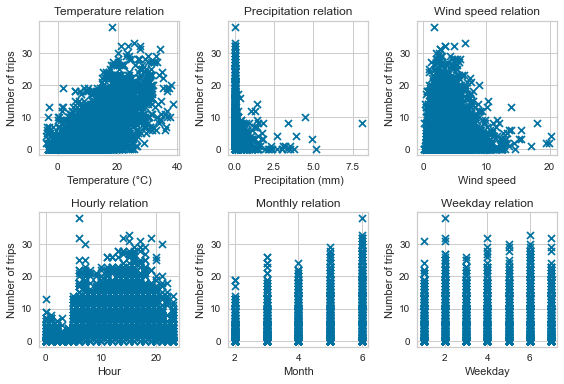

In [11]:
plt.subplot(2,3,1)
plt.xlabel("Temperature (°C)")
plt.ylabel("Number of trips")
plt.title("Temperature relation")
plt.scatter(X_f["temperature"], y_f["num_trips"], marker='x')

plt.subplot(2,3,2)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Number of trips")
plt.title("Precipitation relation")
plt.scatter(X_f["precipitation"], y_f["num_trips"], marker='x')

plt.subplot(2,3,3)
plt.xlabel("Wind speed")
plt.ylabel("Number of trips")
plt.title("Wind speed relation")
plt.scatter(X_f["wind_speed"], y_f["num_trips"], marker='x')

plt.subplot(2,3,4)
plt.xlabel("Hour")
plt.ylabel("Number of trips")
plt.title("Hourly relation")
plt.scatter(X_f["hour"], y_f["num_trips"], marker='x')

plt.subplot(2,3,5)
plt.xlabel("Month")
plt.ylabel("Number of trips")
plt.title("Monthly relation")
plt.scatter(X_f["month"], y_f["num_trips"], marker='x')

plt.subplot(2,3,6)
plt.xlabel("Weekday")
plt.ylabel("Number of trips")
plt.title("Weekday relation")
plt.scatter(X_f["weekday"], y_f["num_trips"], marker='x')

plt.tight_layout()
plt.savefig(path_fig + r'\feature_plotting.png')
plt.show()

Feature correlation with the target value. 

C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


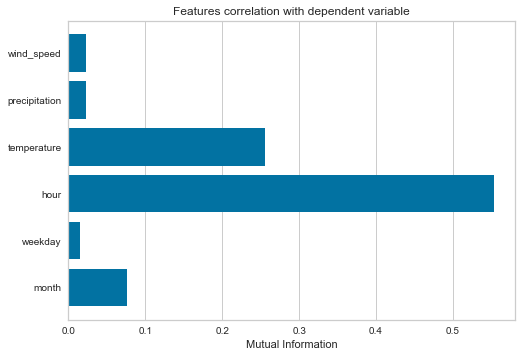

In [12]:
features = np.array(X_b.columns)

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features)

visualizer.fit(X_b, y_b, discrete_features=discrete, random_state=1)
visualizer.show()

# 2. Model training

## 2.1 Splitting and scaling data
Before training the models the data is standardized, since certain models are susceptible to unscaled data.
- X = Features: temperature, precipitation, wind_speed, month, weekday, hour
- y = Target: num_trips

In [13]:
X_f = StandardScaler().fit_transform(X_f)
X_b = StandardScaler().fit_transform(X_b)

The data is then split into a training set and a test set. So that we can use Cross Validation to assess the performance of the models on unseen data.

In [14]:
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.2)

In [15]:
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2)

## 2.2 Linear Regression
First we train a linear regression model on the training set.

In [16]:
model = LinearRegression(fit_intercept = True)
model.fit(X_b_train, y_b_train)

model_pred = model.predict(X_b_test)

print ('The R^2 of linear regression is: ', r2_score(y_b_test, model_pred))
# print ('The mean squared error of linear regression is: ', mean_squared_error(y_b_test, model_pred))

The R^2 of linear regression is:  0.3661890091795621


## 2.3 Polynomial Regression
Secondly we train a polynomial regression models. We decided to use a polynomial regression of degree three as this resulted in the best performance. 

Since the performance improved we tried different variants (Ridge and Lasso regression) to regularize our model and improve the performance.

In [17]:
poly_b = PolynomialFeatures(degree = 3)

X_b_poly = poly_b.fit_transform(X_b)

X_b_train_poly, X_b_test_poly, y_b_train_poly, y_b_test_poly = train_test_split(X_b_poly, y_b, test_size=0.3)

In [18]:
model_poly = LinearRegression(normalize = True)
model_poly.fit(X_b_train_poly,y_b_train_poly)

y_pred = model_poly.predict(X_b_test_poly)

print ('The R^2 for polynomial regression is: ', r2_score(y_b_test_poly, y_pred))
# print ('The mean squared error for polynomial regression is: ', mean_squared_error(y_b_test_poly, y_pred))

The R^2 for polynomial regression is:  0.6343762672427804


In [19]:
model_L2 = Ridge(alpha = 0.1, normalize = True, solver = 'lsqr')

model_L2.fit(X_b_train_poly, y_b_train_poly)
L2_pred = model_L2.predict(X_b_test_poly)

print ('The R^2 for ridge regession is: ', r2_score(y_b_test_poly, L2_pred))
# print ('The mean squared error for ridge regession is: ', mean_squared_error(y_b_test_poly, L2_pred))

The R^2 for ridge regession is:  0.6027287819574487


In [20]:
model_L1 = Lasso(alpha = 0.1, normalize = False)

model_L1.fit(X_b_train_poly, y_b_train_poly)
L1_pred = model_L1.predict(X_b_test_poly)

print ('The R^2 for lasso regession is: ', r2_score(y_b_test_poly, L1_pred))
# print ('The mean squared error for lasso regession is: ', mean_squared_error(y_b_test_poly, L1_pred))

The R^2 for lasso regession is:  0.6421760358822958


C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1130183.426988466, tolerance: 704.8145515274949
  model = cd_fast.enet_coordinate_descent(


## 2.4 Decision Tree Regression
Since the data has a high varianze we also tried a non-linear model. To stop the decision tree from overfitting, the depth is limited to nine.

Different depths were also tried, but underperformed.

In [21]:
tree_reg = DecisionTreeRegressor(max_depth = 9)
tree_reg.fit(X_b_train, y_b_train)

tree_pred = tree_reg.predict(X_b_test)

print ('The R^2 for decision tree regession is: ', r2_score(y_b_test, tree_pred))

The R^2 for decision tree regession is:  0.798782161395658


In [22]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    tree_model = DecisionTreeRegressor(max_depth = tree_depth)
    tree_model.fit(X_b_train, y_b_train)

    dot_data = export_graphviz(tree_model, feature_names=["temperature", "precipitation", "wind_speed", "hour", "month", "weekday"])

    graph = graphviz.Source(dot_data)

    return graph

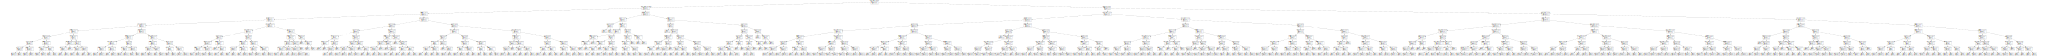

In [23]:
plot_regression_tree_sklearn(9)

## 2.5 Neural Network
The last model we implemented was a neural network, with a simpel multilayer perceptron architecture.

In [24]:
regr = MLPRegressor(hidden_layer_sizes=(20,20,20), random_state=1, max_iter=1000).fit(X_b_train, y_b_train)
pred = regr.predict(X_b_test)

print ('The R^2 for neural network is: ', r2_score(y_b_test, pred))

C:\Users\Steffen\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The R^2 for neural network is:  0.8165097920446294


# 3. Evaluation

In [25]:
performance_data = [["Linear regression model", r2_score(y_b_test, model_pred)], 
     ["Polynomial regression model", r2_score(y_b_test_poly, y_pred)],
     ["Ridge regression", r2_score(y_b_test_poly, L2_pred)],
     ["Lasso regression", r2_score(y_b_test_poly, L1_pred)],
     ["Descsion tree regression", r2_score(y_b_test, tree_pred)],
     ["Neural network", r2_score(y_b_test, pred)]]
    
df_performance = pd.DataFrame(data = performance_data, columns = ["Model", "Performance"])
df_performance

,Model,Performance
0,Linear regression model,0.366189
1,Polynomial regression model,0.634376
2,Ridge regression,0.602729
3,Lasso regression,0.642176
4,Descsion tree regression,0.798782
5,Neural network,0.816510


To evaluate the performance the mean predicted value is plotted against the mean target value for each hour. 

In [26]:
pred = pred.reshape(len(pred),1)

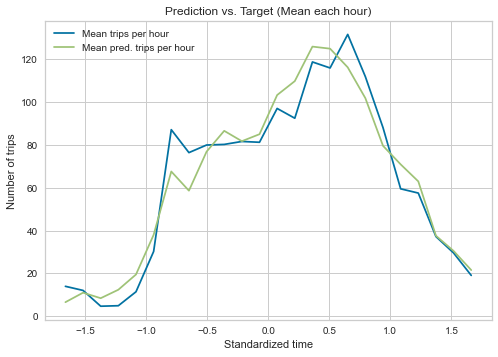

In [27]:
df_plot = pd.DataFrame()
df_plot['hour'] = X_b_test[:, 2]
df_plot['target'] = y_b_test.reset_index(drop=True)
df_plot['pred'] = pred
df_plot = df_plot.groupby(df_plot.hour).mean()
df_plot.sort_index(inplace=True)
plt.plot(df_plot.hour, df_plot.target, label='Mean trips per hour')
plt.plot(df_plot.hour, df_plot.pred, label='Mean pred. trips per hour')
plt.ylabel('Number of trips')
plt.xlabel('Standardized time')
plt.title("Prediction vs. Target (Mean each hour)")
plt.legend()
plt.savefig(path_fig + r'\predicted_trip_hour.png')
plt.show()

## Performance on other cities
The best performing model was trained on the bigger data set from Berlin. The trained model was then tested on the data from Frankfurt. 

In [28]:
pred_frankfurt = regr.predict(X_f)
pred_frankfurt = pred_frankfurt.reshape(len(pred_frankfurt),1)

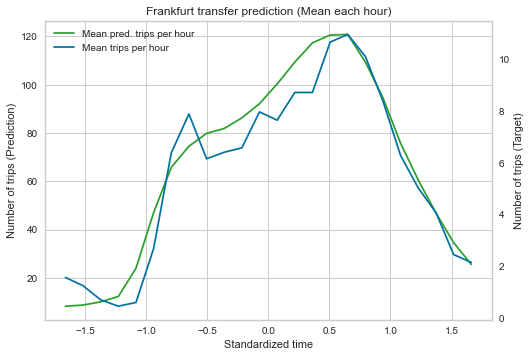

In [29]:
df_plot = pd.DataFrame()
df_plot['hour'] = X_f[:, 2]
df_plot['target'] = y_f.reset_index(drop=True)
df_plot['pred'] = pred_frankfurt
df_plot = df_plot.groupby(df_plot.hour).mean()
df_plot.sort_index(inplace=True)

plt.xlabel('Standardized time')
plt.ylabel('Number of trips (Prediction)')
plt.title("Frankfurt transfer prediction (Mean each hour)")

subplot1 = plt.plot(df_plot.hour, df_plot.pred, label='Mean pred. trips per hour', color = 'tab:green')

subplot = plt.twinx()
subplot.set_ylabel('Number of trips (Target)')

subplot2 = subplot.plot(df_plot.hour, df_plot.target, label='Mean trips per hour')

comb = subplot1 + subplot2
lab = [l.get_label() for l in comb]
plt.legend(comb, lab, loc=0)

plt.grid(False)
plt.savefig(path_fig + r'\frankfurt_prediction.png')
plt.show()